# Executive Summary

Goals: Build a new regression model to predict logerror (log(Zestimate) - log(SalePrice)), and use clustering to see if we can find groups of similar observations to generate new features to be fed into our supervised model.

Best Features: 

Takeaways: N/A

In [1]:
#imports
import os
import pandas as pd
from env import username, host, password 
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from wrangle import get_zillow_data, prepare_zillow, train_validate_test_split, train_validate_test, impute_nulls, split_X_y, standard_scale_data, get_object_cols, get_numeric_X_cols, nulls_by_col, nulls_by_row  
from explore import explore_univariate, create_cluster, create_scatter_plot, get_zillow_heatmap

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE
import statsmodels.api as sm
from sklearn.metrics import explained_variance_score

# Acquire Stage 

In [2]:
#acquire our Zillow data from CodeUp server by parcel id specifically those that are single unit property values.
df = get_zillow_data()

In [3]:
df.shape

(77575, 68)

In [4]:
df

,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,id,basementsqft,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,NaN,NaN,261.0,NaN,NaN,NaN,NaN,14297519,1727539,NaN,...,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,NaN,NaN,261.0,NaN,NaN,NaN,NaN,17052889,1387261,NaN,...,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,NaN,NaN,261.0,NaN,NaN,NaN,NaN,14186244,11677,NaN,...,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,NaN,NaN,261.0,2.0,NaN,NaN,NaN,12177905,2288172,NaN,...,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,NaN,NaN,266.0,2.0,NaN,NaN,1.0,10887214,1970746,NaN,...,6.037124e+13,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77570,NaN,NaN,266.0,2.0,NaN,NaN,1.0,10833991,2864704,NaN,...,6.037132e+13,-0.002245,2017-09-20,Central,NaN,NaN,Central,Condominium,NaN,NaN
77571,NaN,NaN,261.0,2.0,NaN,NaN,NaN,11000655,673515,NaN,...,6.037101e+13,0.020615,2017-09-20,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
77572,NaN,NaN,261.0,NaN,NaN,NaN,NaN,17239384,2968375,NaN,...,6.111008e+13,0.013209,2017-09-21,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
77573,NaN,NaN,261.0,2.0,NaN,NaN,1.0,12773139,1843709,NaN,...,6.037434e+13,0.037129,2017-09-21,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN


In [5]:
df.isnull().sum()[df.isnull().sum()>0]

typeconstructiontypeid          77353
storytypeid                     77525
heatingorsystemtypeid           28005
buildingclasstypeid             77560
architecturalstyletypeid        77369
airconditioningtypeid           52569
basementsqft                    77525
buildingqualitytypeid           27766
calculatedbathnbr                 615
decktypeid                      76961
finishedfloor1squarefeet        71540
calculatedfinishedsquarefeet      200
finishedsquarefeet12             3655
finishedsquarefeet13            77533
finishedsquarefeet15            74548
finishedsquarefeet50            71540
finishedsquarefeet6             77189
fireplacecnt                    69288
fullbathcnt                       615
garagecarcnt                    52058
garagetotalsqft                 52058
hashottuborspa                  76036
lotsizesquarefeet                8257
poolcnt                         61402
poolsizesum                     76706
pooltypeid10                    77110
pooltypeid2 

In [10]:
nulls_by_col(df)

<class 'pandas.core.series.Series'>


,num_rows_missing,percent_rows_missing
typeconstructiontypeid,77353,99.713825
storytypeid,77525,99.935546
propertylandusetypeid,0,0.000000
heatingorsystemtypeid,28005,36.100548
buildingclasstypeid,77560,99.980664
...,...,...
buildingclassdesc,77560,99.980664
heatingorsystemdesc,28005,36.100548
propertylandusedesc,0,0.000000
storydesc,77525,99.935546


In [11]:
nulls_by_row(df)

,num_cols_missing,percent_cols_missing,num_rows
0,23,33.82352941176471,2
1,24,35.294117647058826,13
2,25,36.76470588235294,24
3,26,38.23529411764706,65
4,27,39.705882352941174,316
5,28,41.17647058823529,457
6,29,42.64705882352941,5285
7,30,44.11764705882353,3465
8,31,45.588235294117645,9911
9,32,47.05882352941176,12606


In [12]:
df = prepare_zillow(df)

In [13]:
df.shape

(49727, 47)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49727 entries, 0 to 77574
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   propertylandusetypeid       49727 non-null  float64
 1   parcel_id                   49727 non-null  int64  
 2   id                          49727 non-null  int64  
 3   baths                       49727 non-null  float64
 4   beds                        49727 non-null  float64
 5   calculatedbathnbr           49713 non-null  float64
 6   sqft                        49727 non-null  float64
 7   finishedsquarefeet12        49546 non-null  float64
 8   fullbathcnt                 49713 non-null  float64
 9   latitude                    49727 non-null  float64
 10  longitude                   49727 non-null  float64
 11  lotsizesquarefeet           49727 non-null  float64
 12  propertycountylandusecode   49727 non-null  object 
 13  rawcensustractandblock      497

In [14]:
#split into train, validate, test. Our target is logerror
train, validate, test = train_validate_test_split(df, 'logerror', seed=1349)

In [15]:
#return our train, validate, and test sets with calculatedbathnbr, fullbathcnt, regionidcity, regionidzip,censustractandblock
#imputed with most frequent values
train, validate, test = impute_nulls(train, validate, test, strategy='most_frequent', 
                        col_list=['calculatedbathnbr', 'fullbathcnt', 'regionidcity', 'regionidzip', 'censustractandblock'])

In [16]:
#return our train, validate, and test sets with finishedsquarefeet12, lotsizesquarefeet, structuretaxvaluedollarcnt, 
#tax_value, land tax value dollar count, and tax amount imputed with the column's median value. 
train, validate, test = impute_nulls(train, validate, test, strategy='median', 
                        col_list=['finishedsquarefeet12', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt', 
                                  'tax_value', 'landtaxvaluedollarcnt', 'tax_amount'])

In [17]:
#drop rows with remaining nulls from all of our split sets
train = train.dropna()
validate = validate.dropna()
test = test.dropna()

In [28]:

#assuring there are no more nulls and we can almost get to work
train.isna().sum().sum() + validate.isna().sum().sum() + test.isna().sum().sum()

0

In [29]:
#split new train, validate, and test into X_train, y_train, X_validate, y_validate, X_test, y_test with logerror as our target
X_train, y_train, X_validate, y_validate, X_test, y_test = split_X_y(train, validate, test, 'logerror')

In [30]:
#get object columns, and numeric columns so we can scale our data
obj_cols = get_object_cols(X_train)
num_cols = get_numeric_X_cols(X_train, obj_cols)

In [31]:
obj_cols

['propertycountylandusecode',
 'transactiondate',
 'propertylandusedesc',
 'county']

In [32]:
num_cols

['propertylandusetypeid',
 'parcel_id',
 'id',
 'baths',
 'beds',
 'calculatedbathnbr',
 'sqft',
 'finishedsquarefeet12',
 'fullbathcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'rawcensustractandblock',
 'regionidcity',
 'regionidzip',
 'roomcnt',
 'year_built',
 'structuretaxvaluedollarcnt',
 'tax_value',
 'assessmentyear',
 'landtaxvaluedollarcnt',
 'tax_amount',
 'censustractandblock',
 'LA',
 'Orange',
 'Ventura',
 'age',
 'age_bin',
 'taxrate',
 'acres',
 'acres_bin',
 'sqft_bin',
 'structure_dollar_per_sqft',
 'structure_dollar_sqft_bin',
 'land_dollar_per_sqft',
 'lot_dollar_sqft_bin',
 'bath_bed_ratio',
 'cola',
 'los_angeles',
 'orange',
 'ventura',
 'bathsandbeds']

In [21]:
#scale our X_train, X_validate, and X_test with standard scaler
X_train_scaled, X_validate_scaled, X_test_scaled = standard_scale_data(X_train[num_cols],X_validate[num_cols],X_test[num_cols])

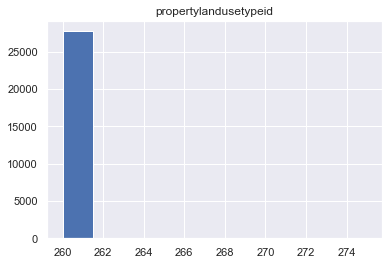

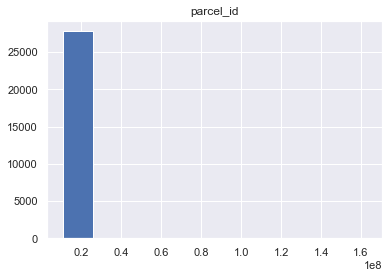

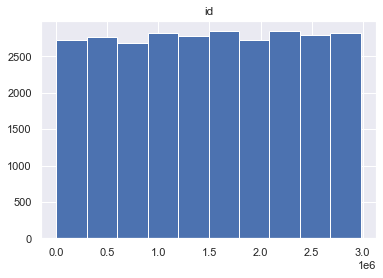

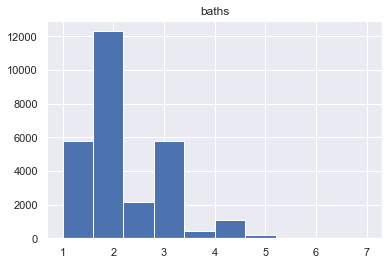

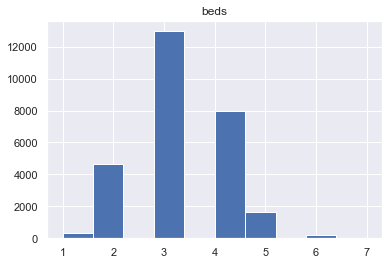

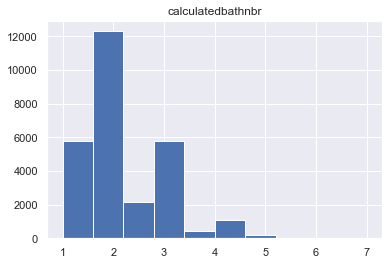

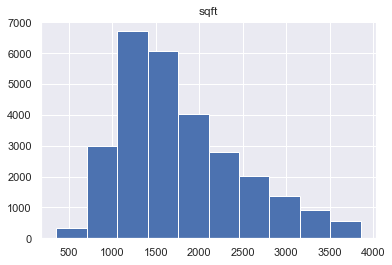

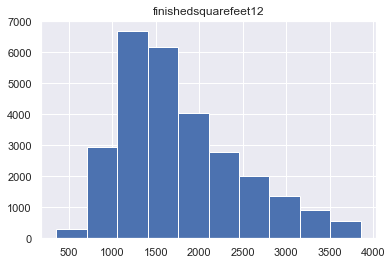

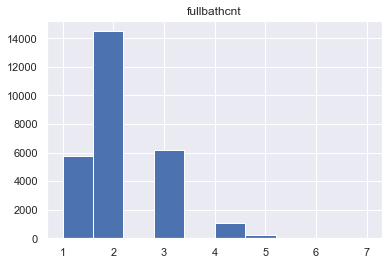

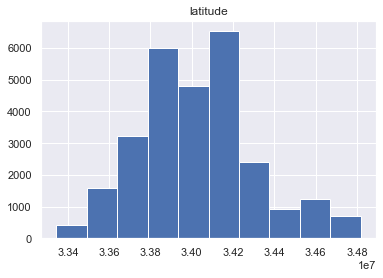

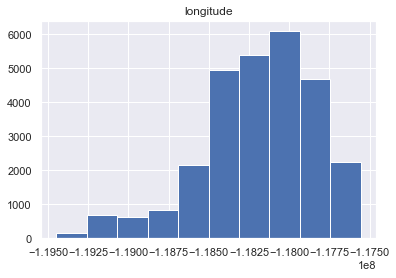

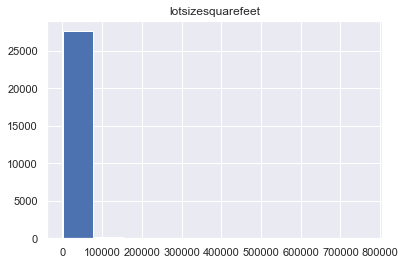

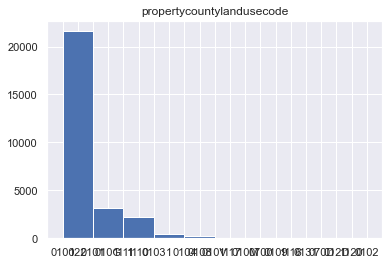

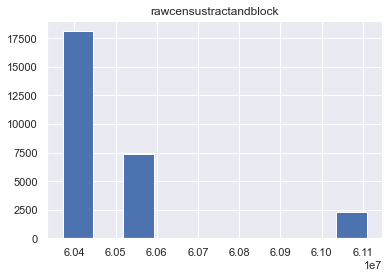

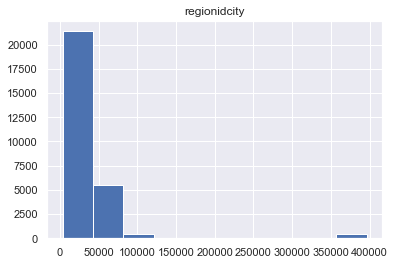

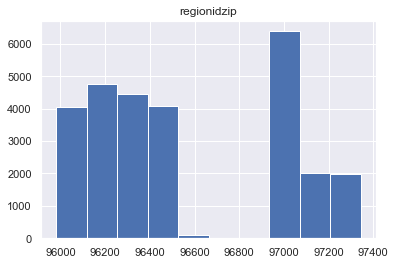

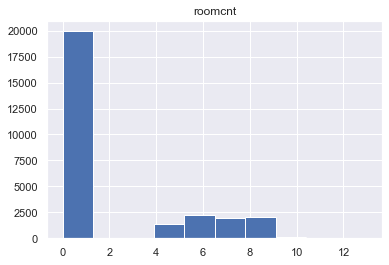

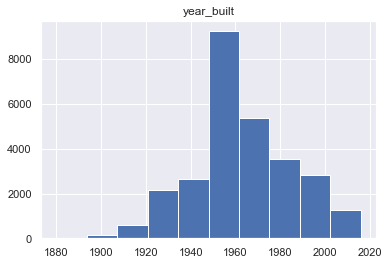

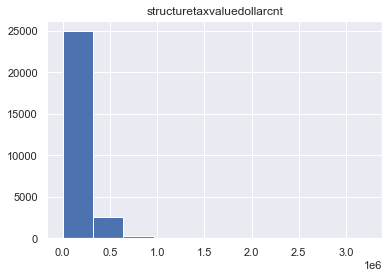

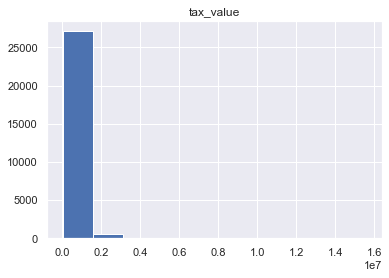

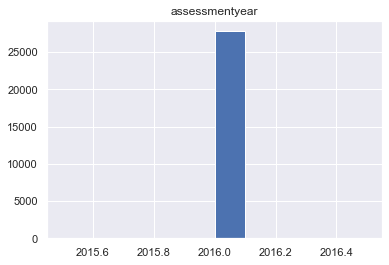

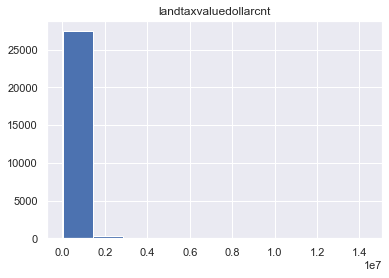

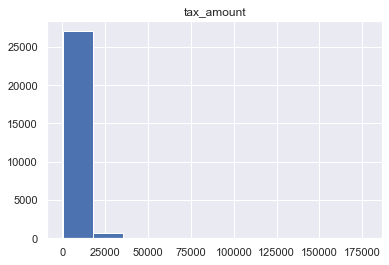

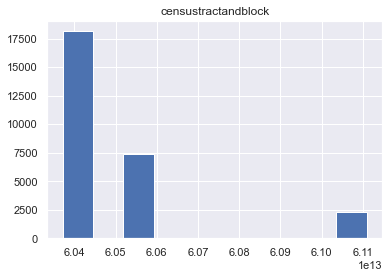

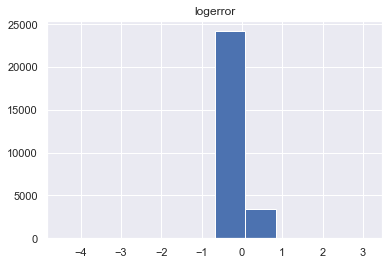

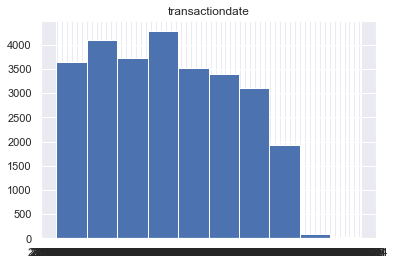

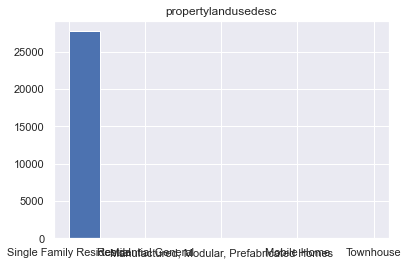

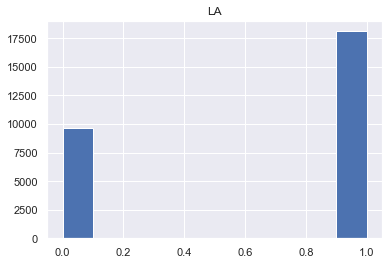

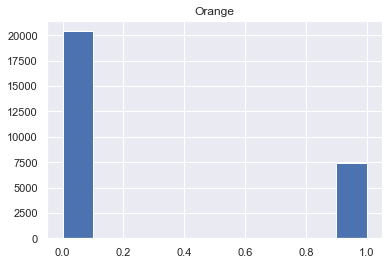

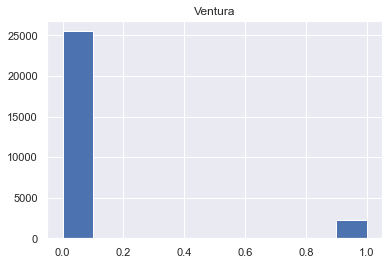

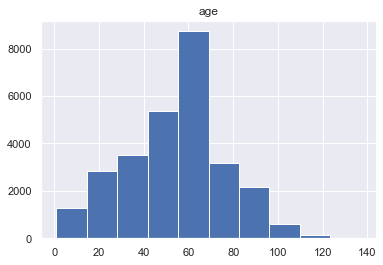

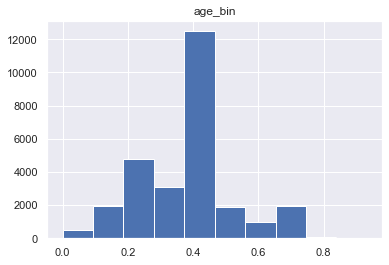

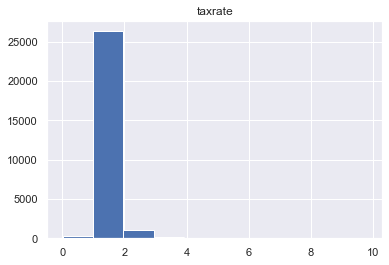

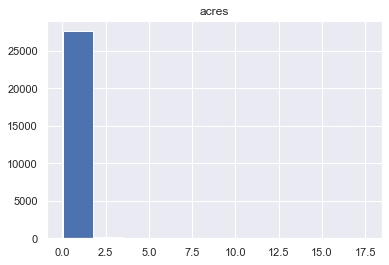

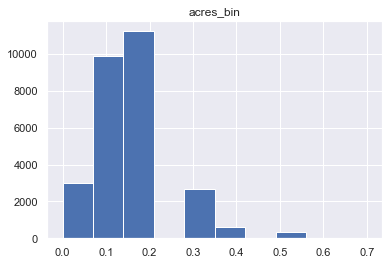

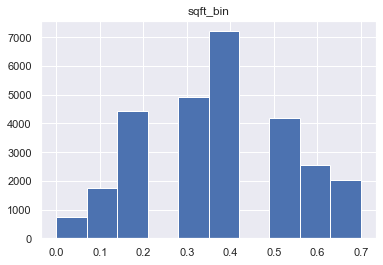

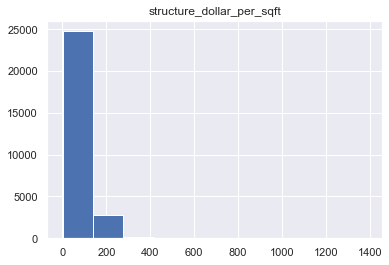

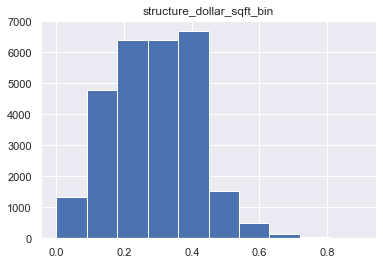

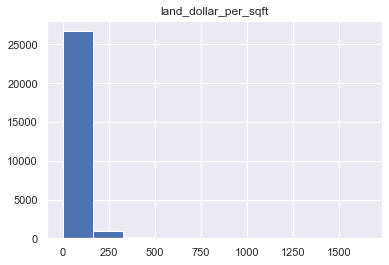

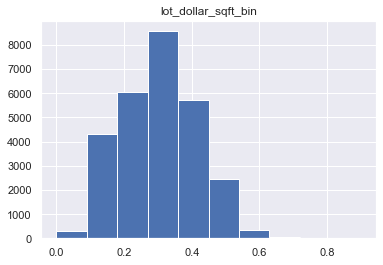

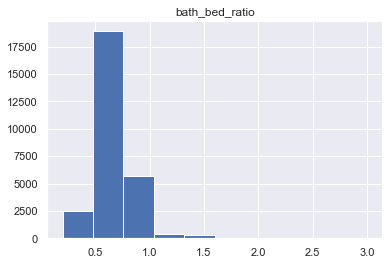

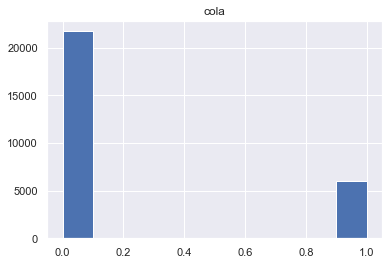

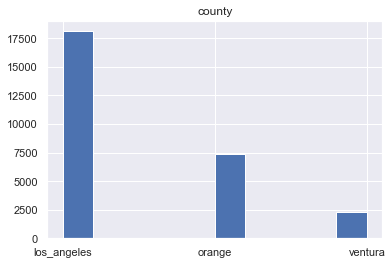

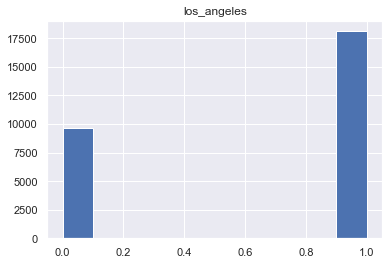

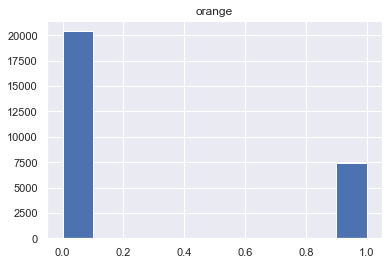

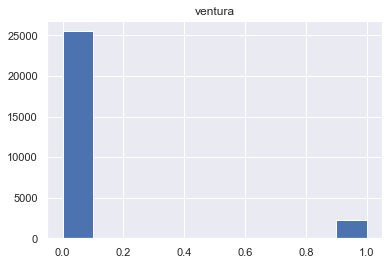

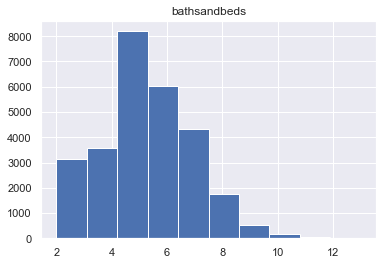

In [34]:
for col in train.columns:
    plt.hist(train[col])
    plt.title(col)
    plt.show()

<AxesSubplot:title={'center':'Feautures Correlating with Log Error'}>

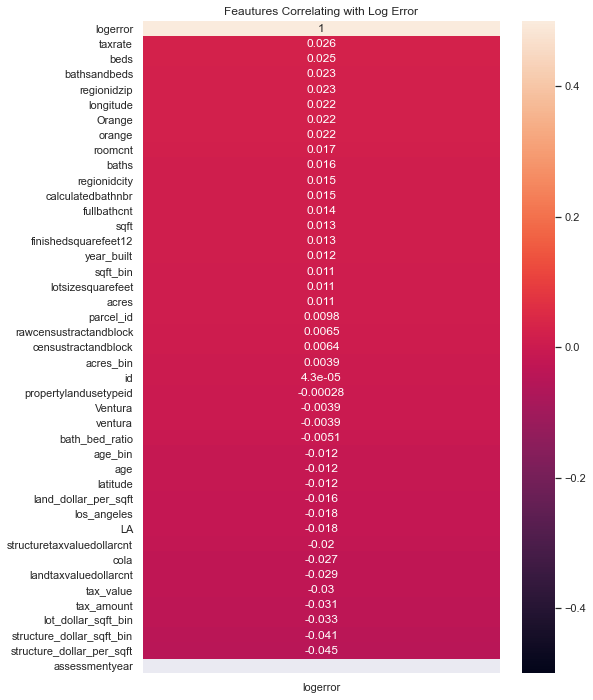

In [33]:
get_zillow_heatmap(train)

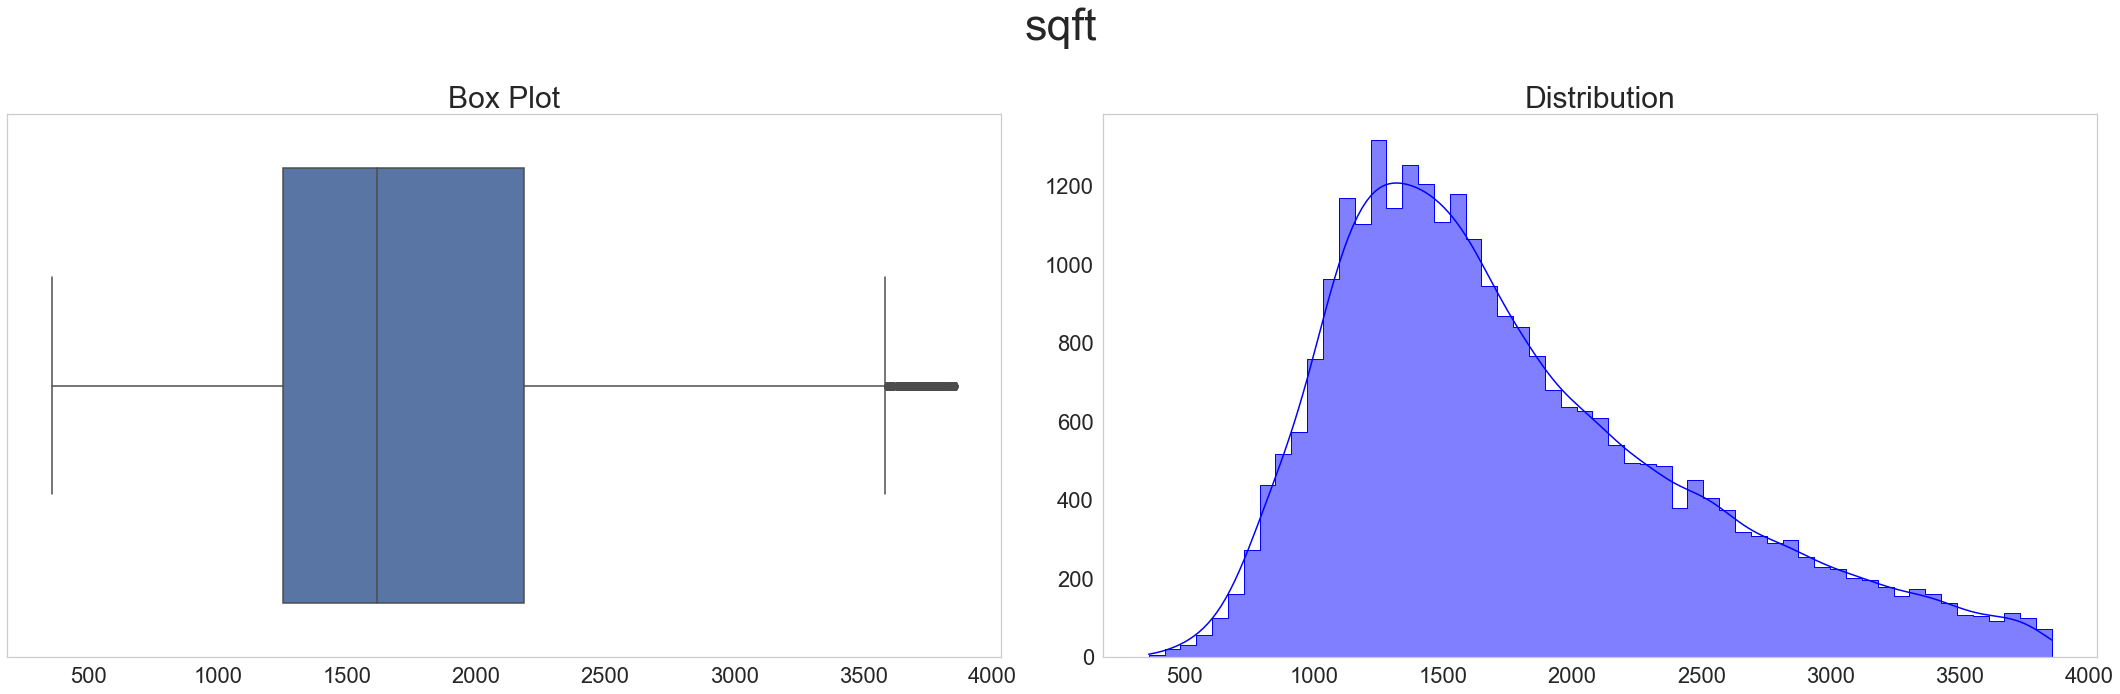

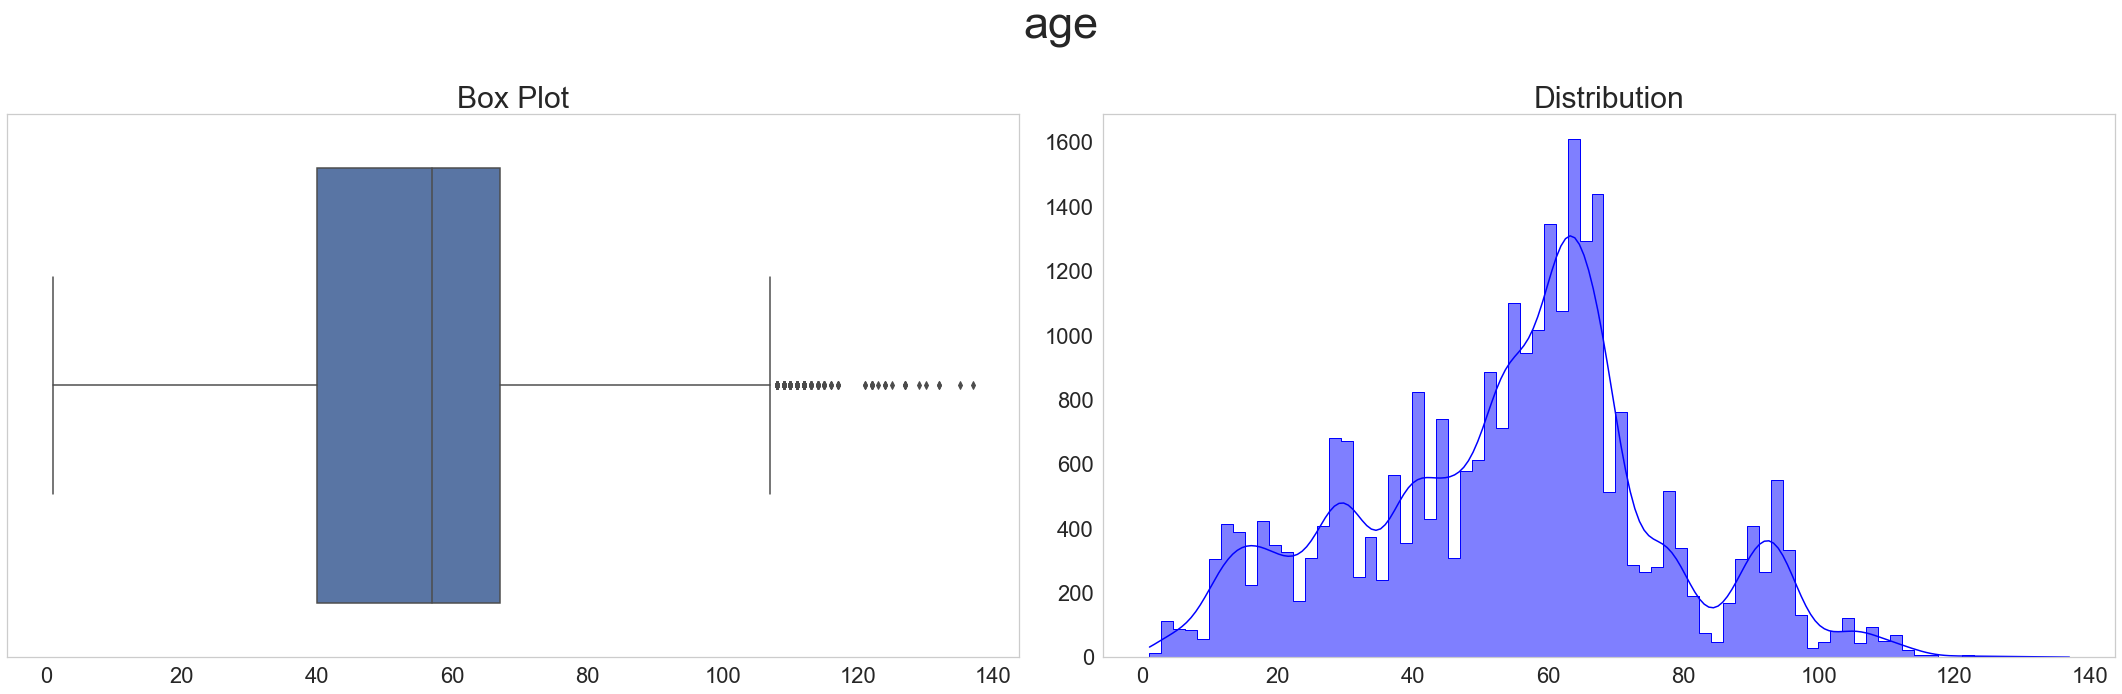

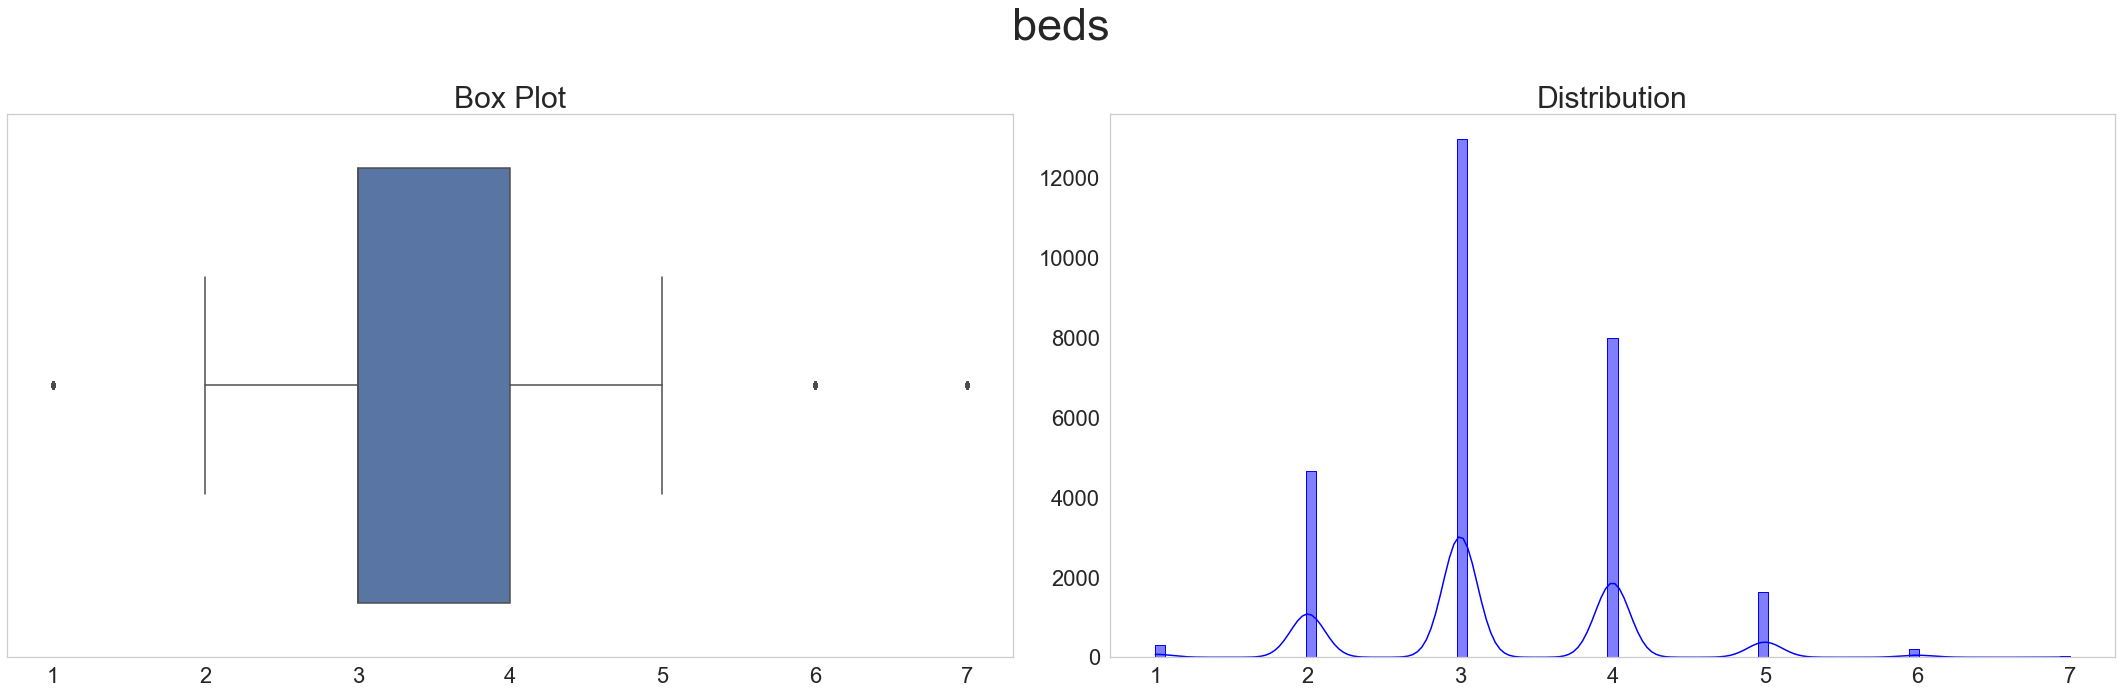

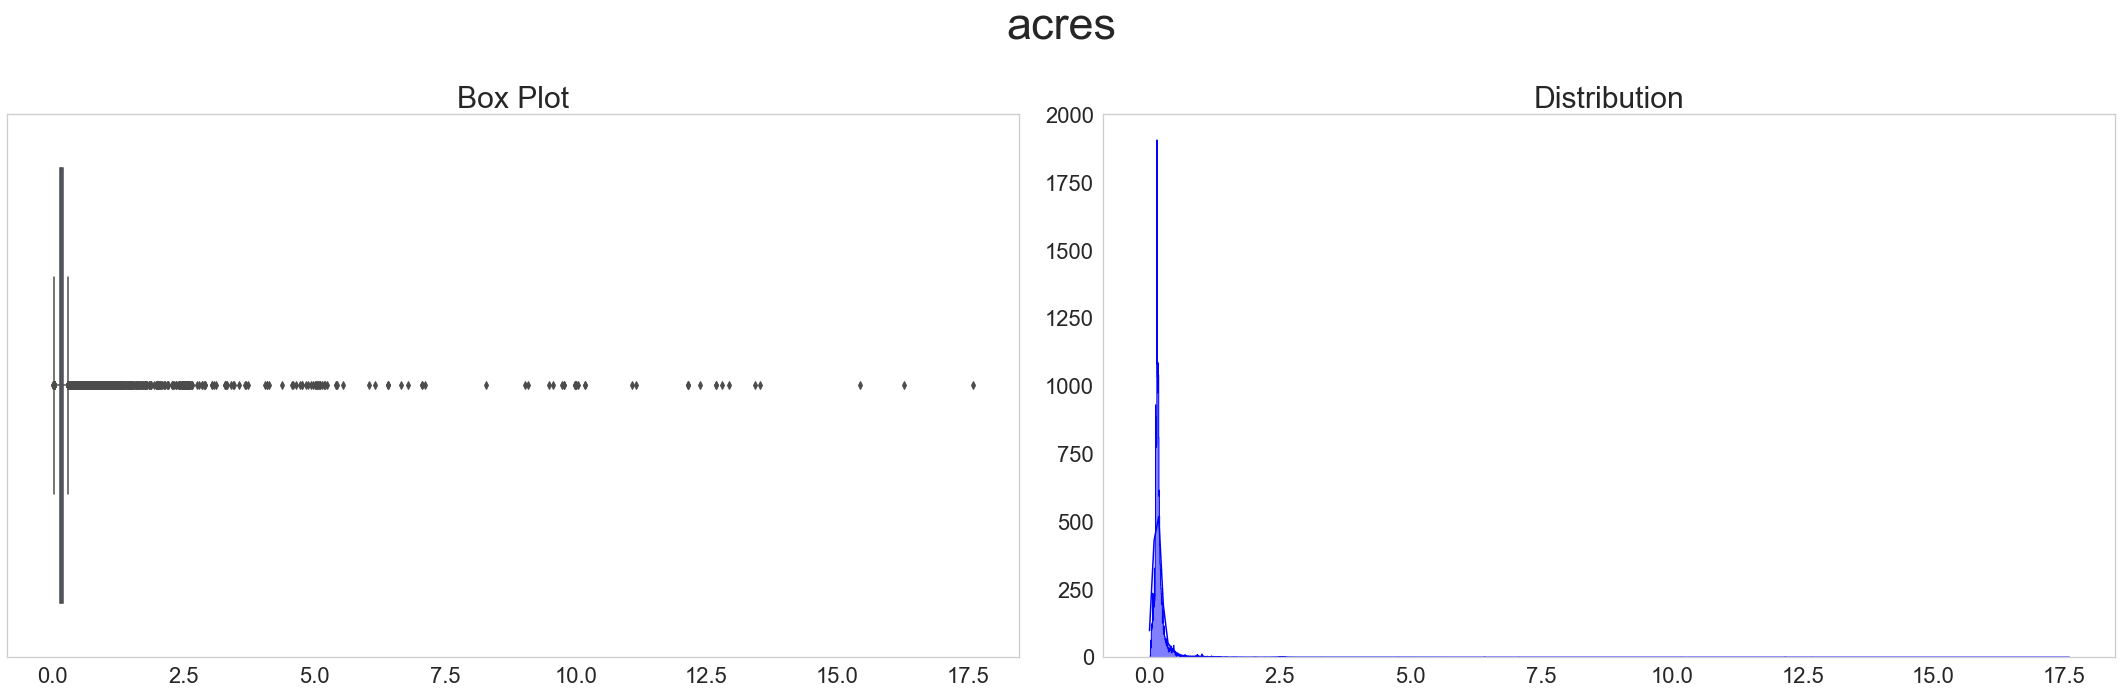

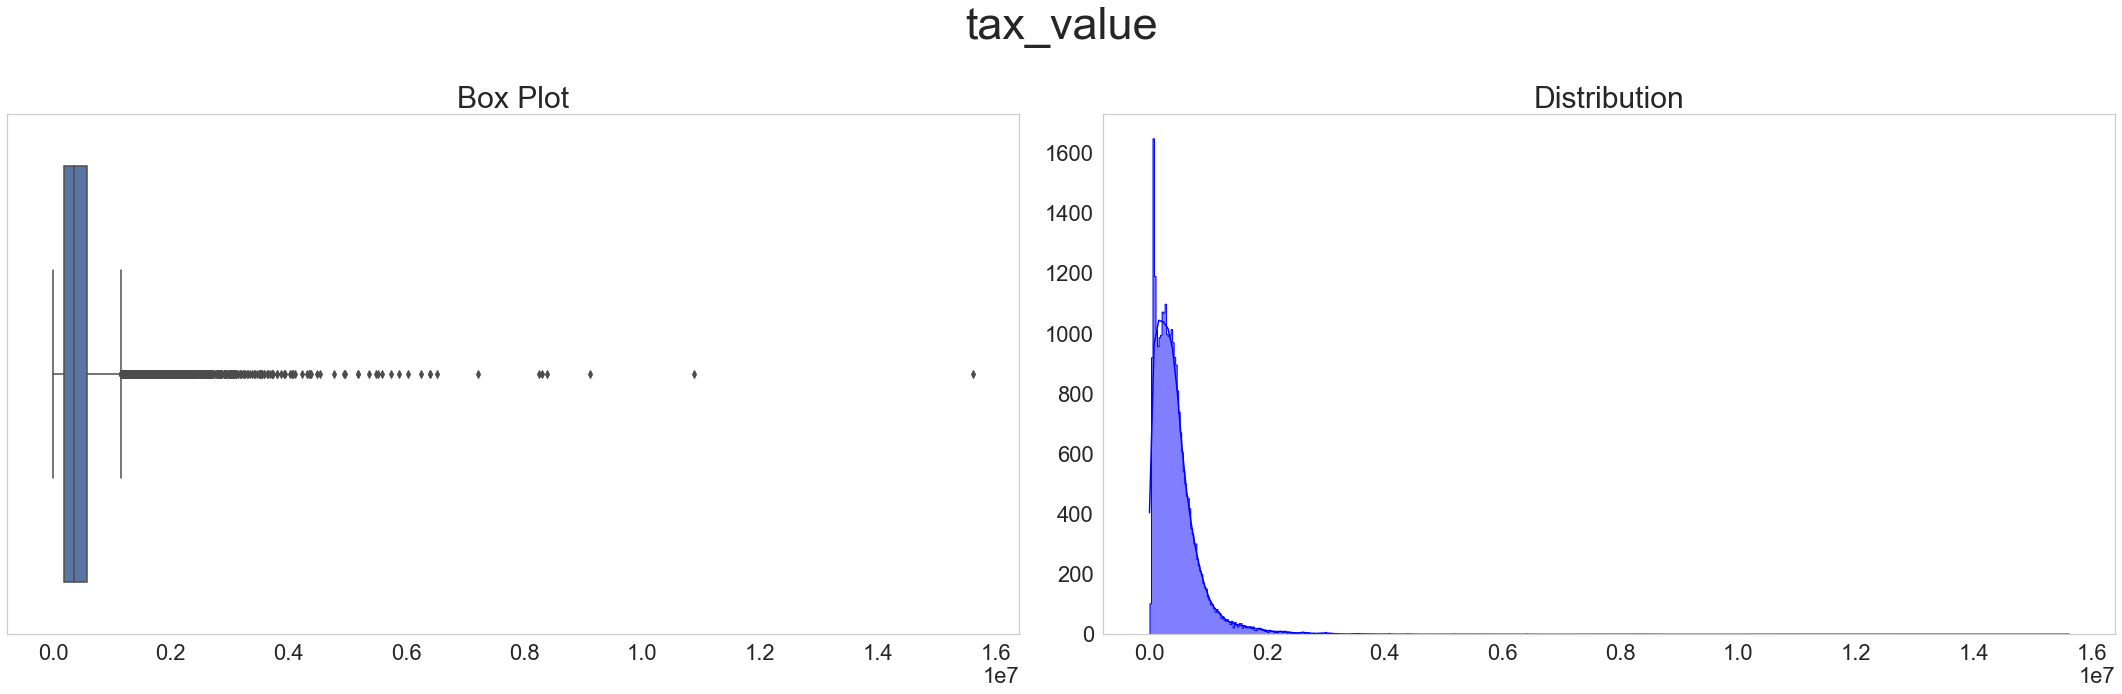

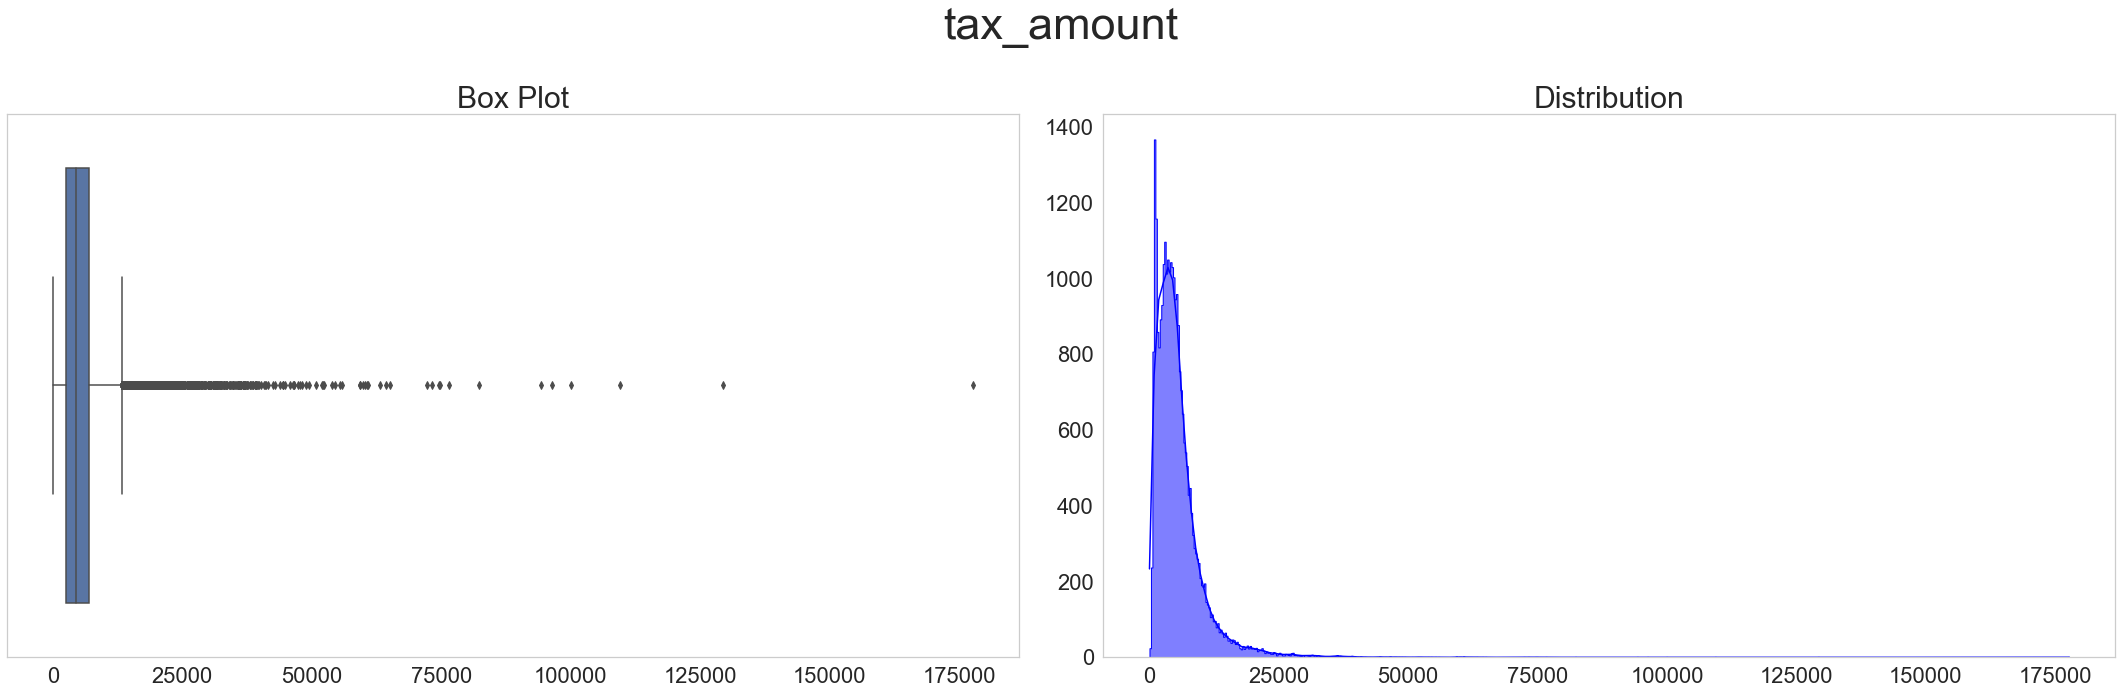

In [36]:
univariate_study = ['sqft','age','beds','acres','tax_value','tax_amount']

for i in univariate_study:
    explore_univariate(train, i)

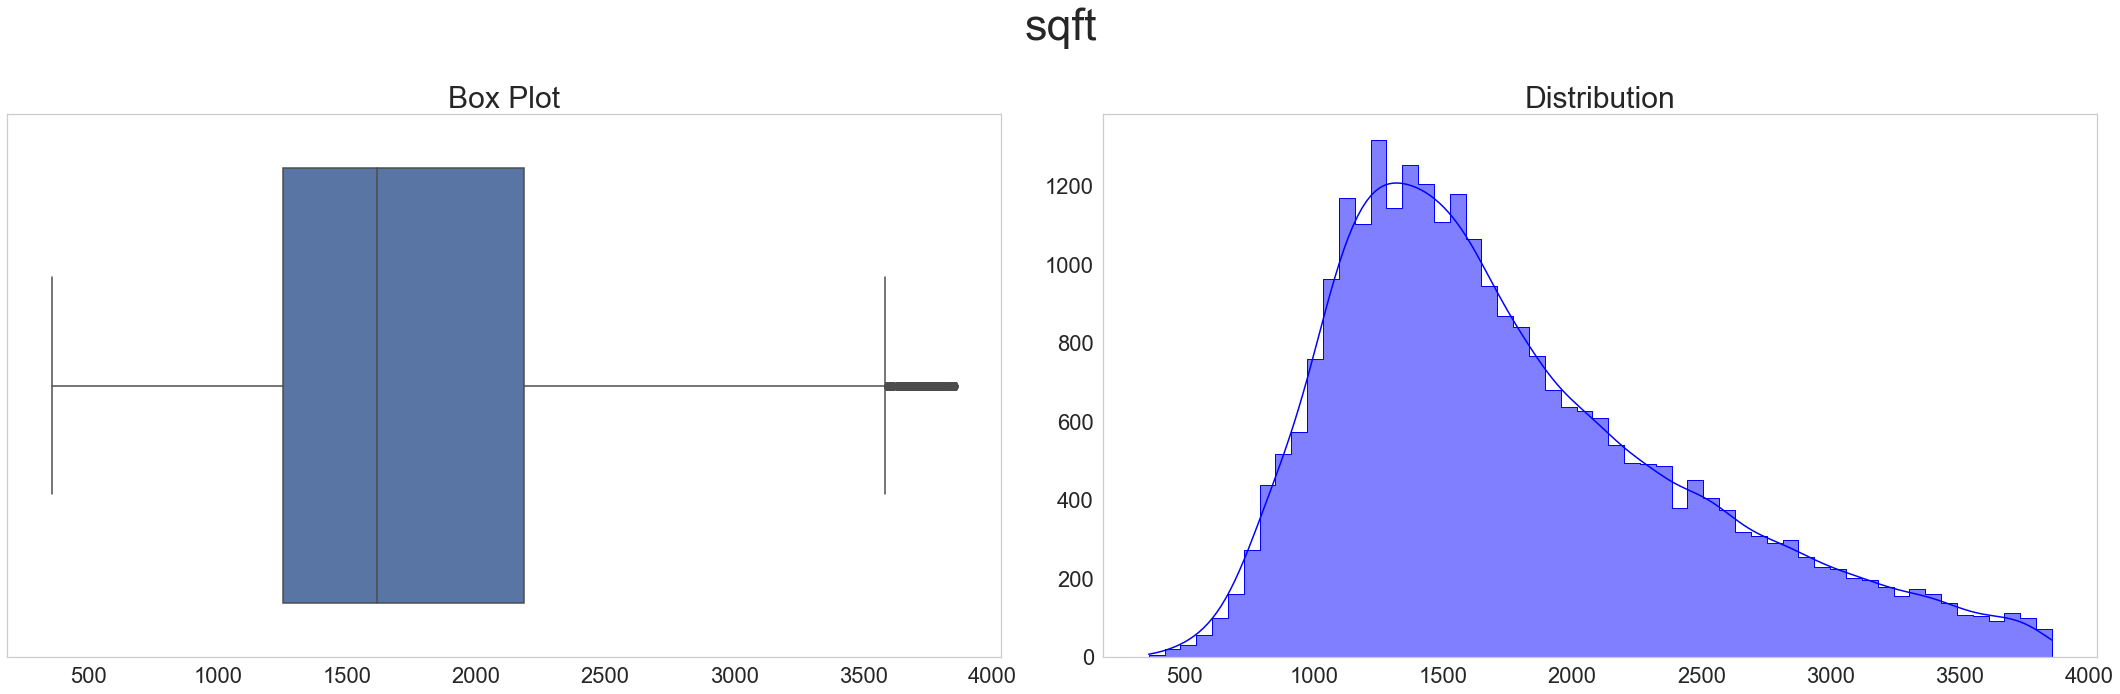

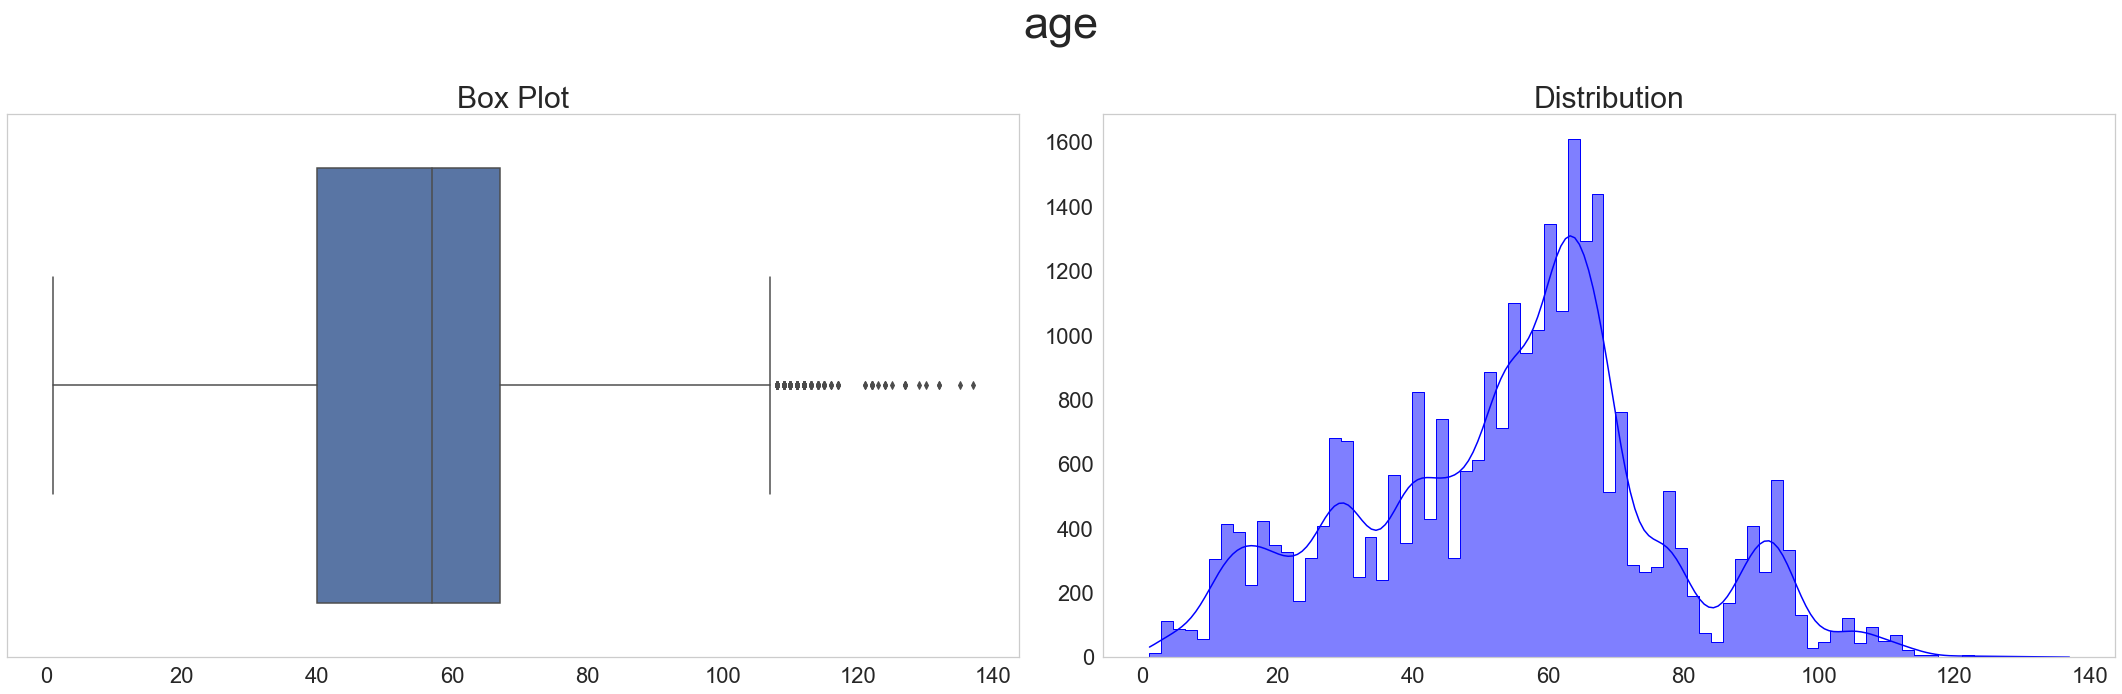

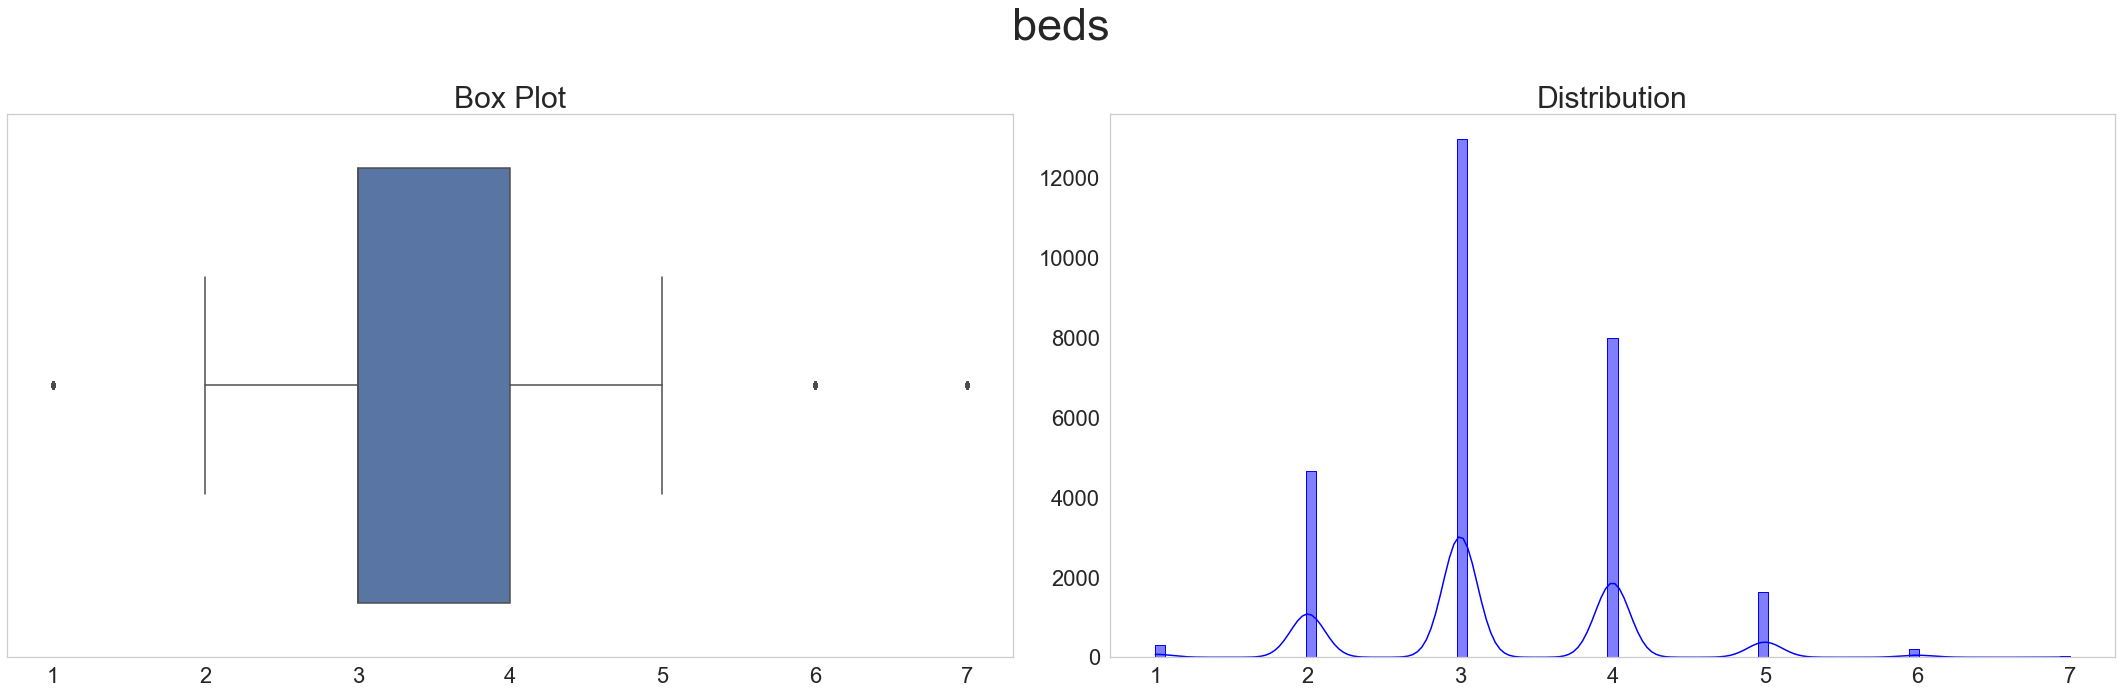

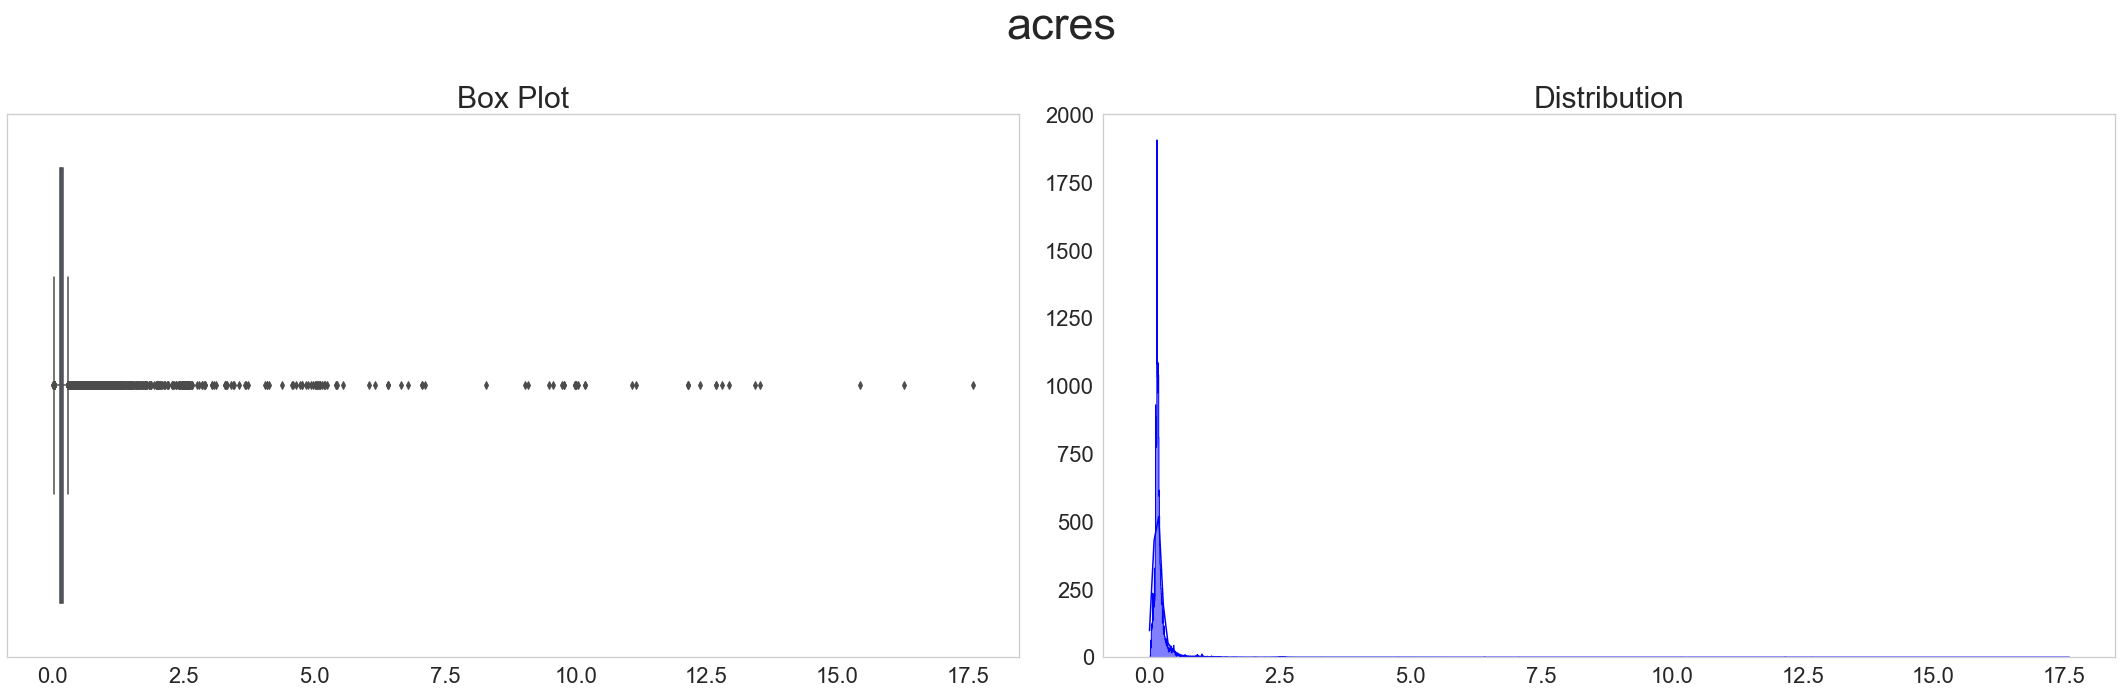

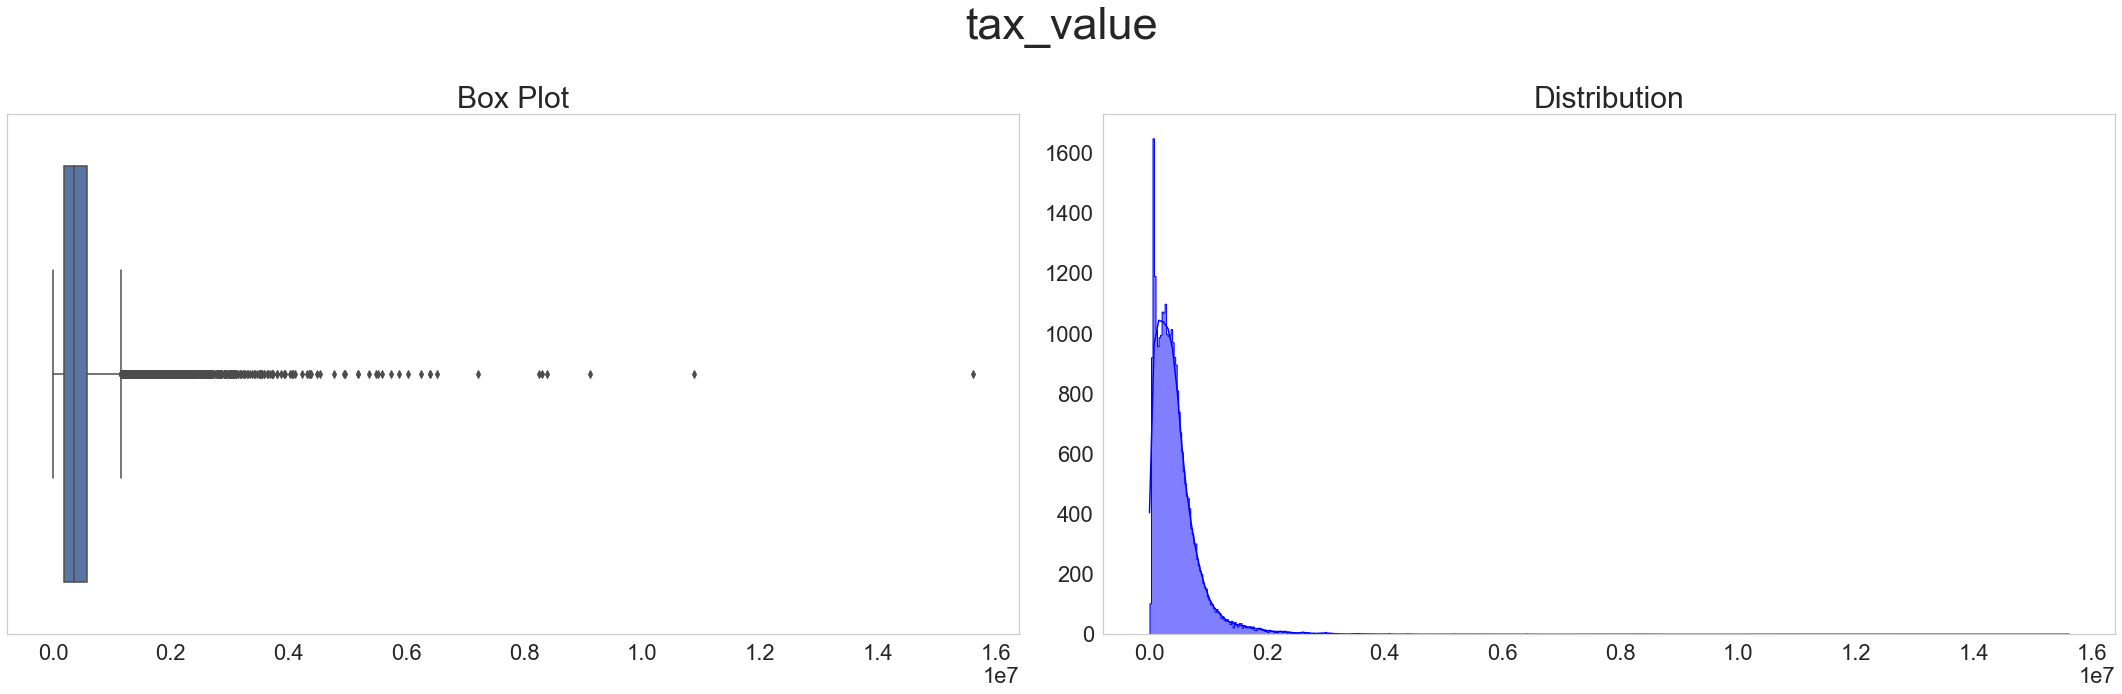

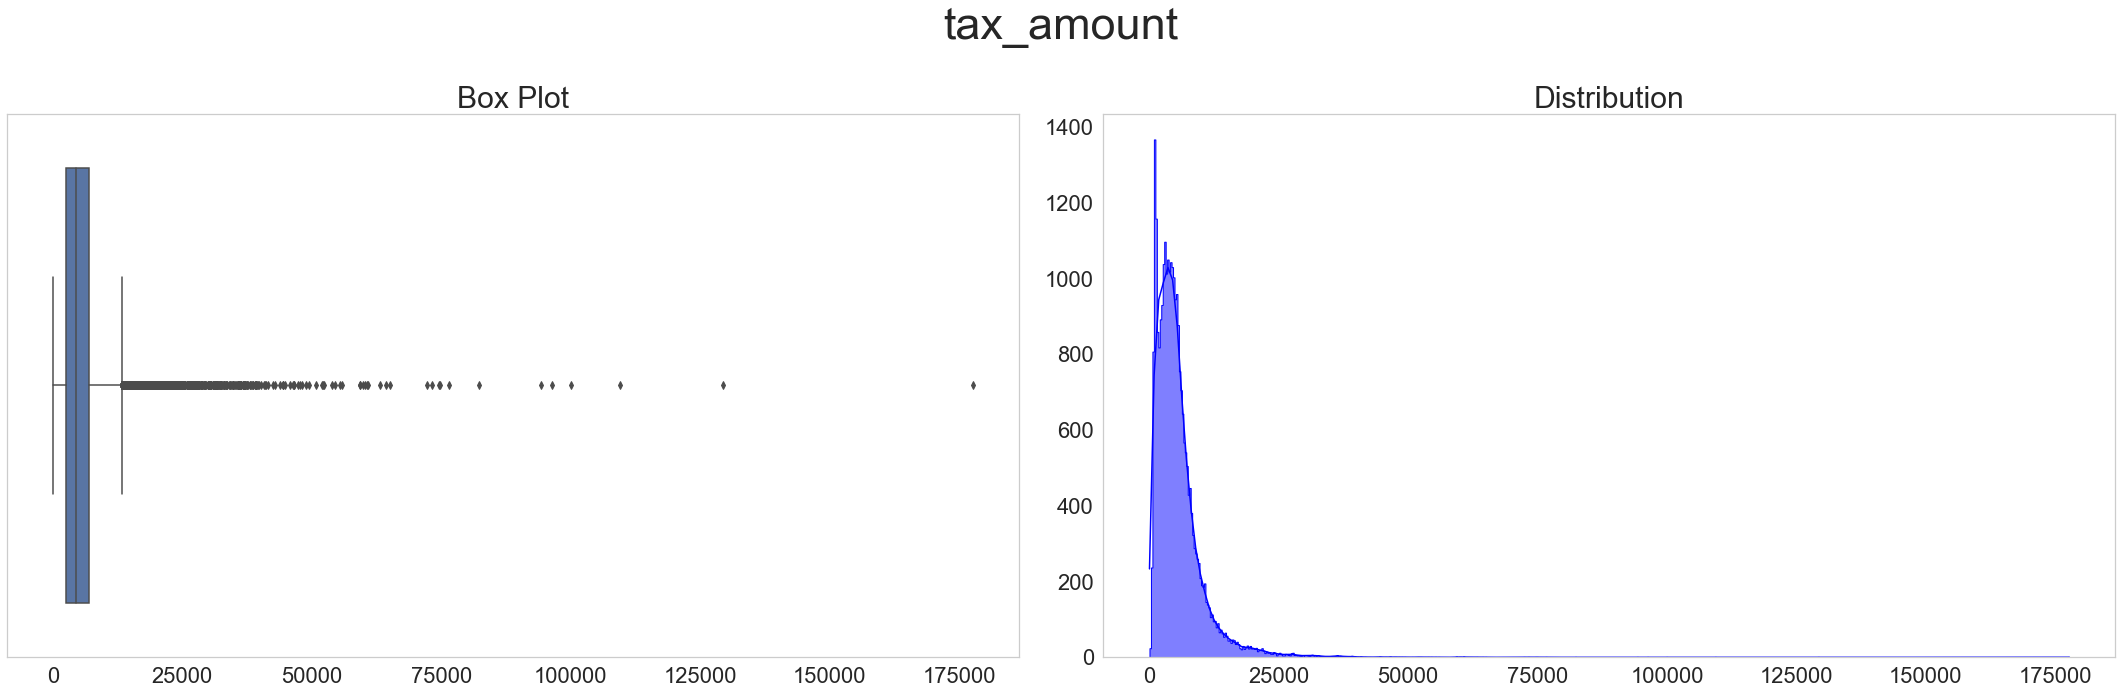

In [37]:
explore_univariate(train, 'sqft')


explore_univariate(train, 'age')


explore_univariate(train, 'beds')


explore_univariate(train, 'acres')

explore_univariate(train, 'tax_value')

explore_univariate(train, 'tax_amount')


# Bivariate Exploration

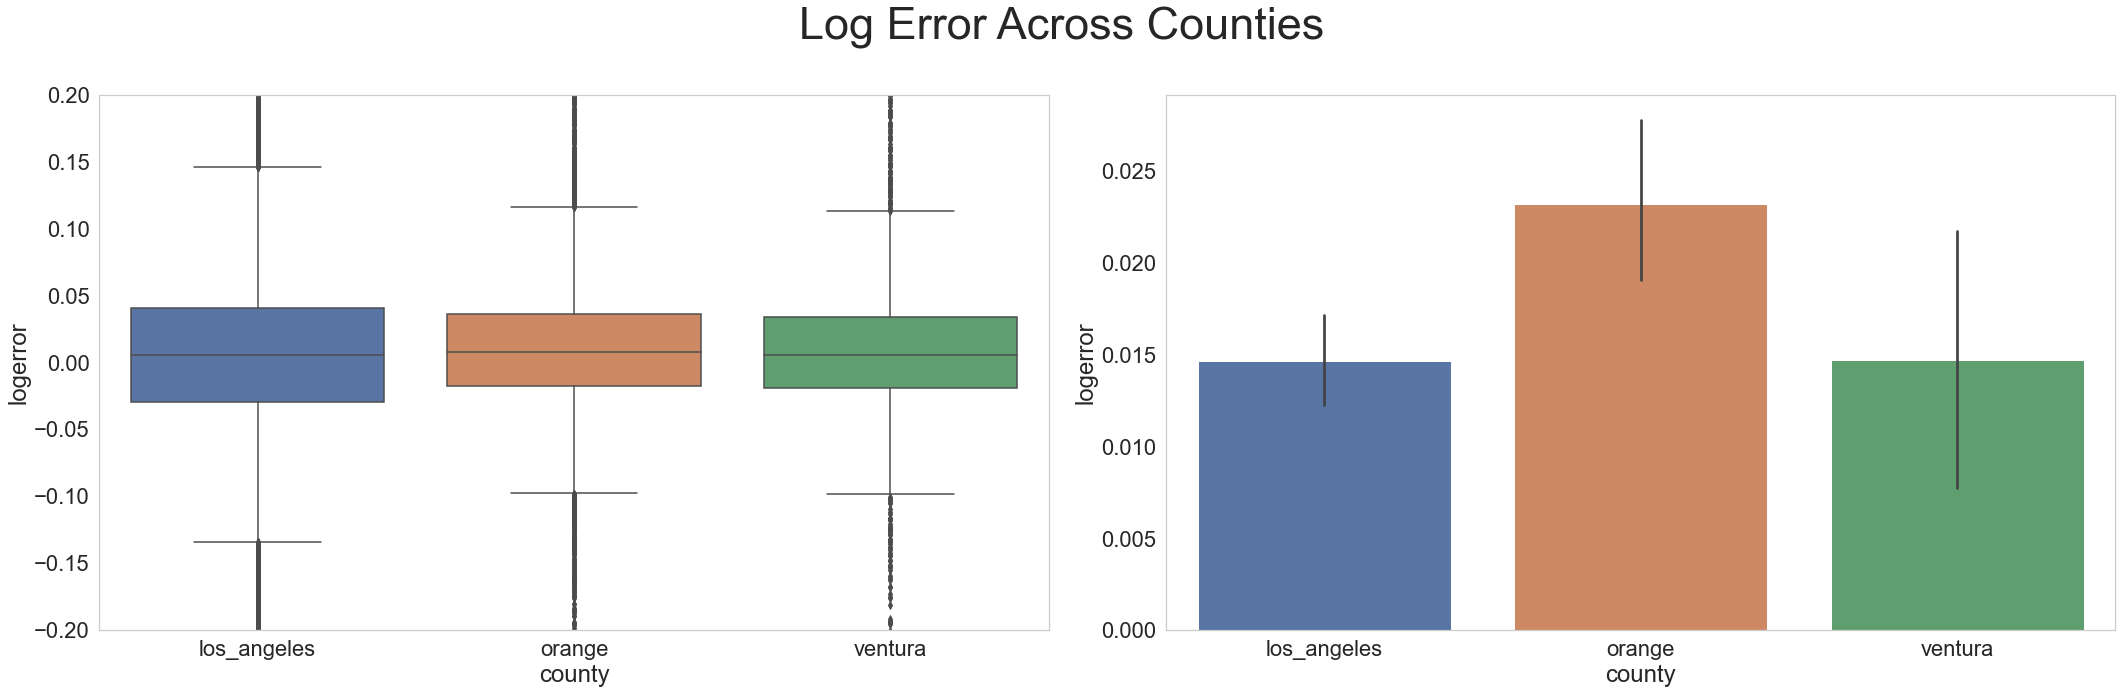

In [38]:
#logerror across counties (LA, Orange, and Ventura)

#set up figure size, font size, and turn off grid.
plt.figure(figsize=(30,10))
sns.set(font_scale = 2)
sns.set_style("whitegrid", {'axes.grid' : False})

#boxplot
plt.subplot(1, 2, 1)
sns.boxplot(train.county, train.logerror)
plt.ylim(-.2, .2)

#barplot
plt.subplot(1, 2, 2)
sns.barplot(data=train, x='county',y='logerror')

#title
plt.suptitle('Log Error Across Counties', fontsize = 45)
plt.tight_layout()
plt.show()

In [39]:
null_hypothesis = "no difference in logerror between ventura county and the other counties"
alternative_hypothesis = "there is a difference in log error between ventura county and other counties"
a = 0.05 #a for alpha 

ventura_logerror=train[train.county=='ventura'].logerror
other_logerror = train[train.county!='ventura'].logerror
t, p = stats.ttest_ind(ventura_logerror, other_logerror)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Fail to reject null hypothesis that: no difference in logerror between ventura county and the other counties There is not sufficient evidence to reject it.


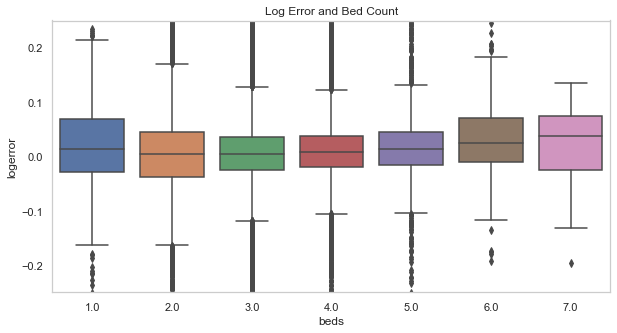

In [40]:
#Log error and number of beds
plt.figure(figsize=(10,5))
sns.set(font_scale = 1)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.boxplot(train.beds, train.logerror)
plt.title('Log Error and Bed Count')
plt.ylim(-.25, .25)
plt.show()

In [44]:
null_hypothesis = "no difference in logerror between properties with 2 beds or less, or more beds"
alternative_hypothesis = "there is a difference in logerror between properties with 2 beds or less, or more beds"
a = 0.05 #a for alpha 

two_or_less_beds=train[train.beds<=2].logerror
more_than_two_beds = train[train.beds>2].logerror
t, p = stats.ttest_ind(two_or_less_beds, more_than_two_beds)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Fail to reject null hypothesis that: no difference in logerror between properties with 2 beds or less, or more beds There is not sufficient evidence to reject it.


Acres and LogError


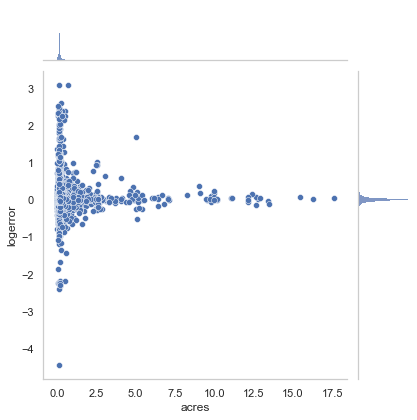

In [45]:
print('Acres and LogError')
sns.jointplot(x='acres', y='logerror', data=train)
plt.xlabel('Acres')
plt.ylabel('Log Error')
plt.show()

In [46]:
null_hypothesis = "no difference in logerror between properties 2 acres or less, or with more acres"
alternative_hypothesis = "there is a difference in logerror between properties 2 acres or less, or with more acres"
a = 0.05 #a for alpha 

More_land=train[train.acres<=2].logerror
less_land = train[train.acres>2].logerror
t, p = stats.ttest_ind(More_land, less_land)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: no difference in logerror between properties 2 acres or less, or with more acres
There is evidence to suggest: there is a difference in logerror between properties 2 acres or less, or with more acres
